In [1]:
%load_ext autoreload

# Examples of using GRLP

GRLP is a model for the long-profile evolution of a fluvial channel with a semi-implicit solver built in. 
The model takes a few basic inputs, and since the numerical solver has been set up implicitly, the model can take long timesteps while remaining stable. 
As its basic inputs, the model takes a sediment and water input, a spatial domain, an uplift rate, and a floodplain width, plus a slew of appropriate constants. 
The model can also replace some of these with a set of power-law scaling relationships between downstream distance and (1) valley width, (2) drainage area, and (3) discharge.
If this approach is taken, it allows an analytical solution, assuming that these variables *actually* follow a power-law downstream. 
However, for the numerical solution, these can be an arbitrary functions up and downstream, instead of power laws. 

First, we will present an example where we compare the numerical solution with power-law functions for important variables to the corresponding analytical solution, which will demonstrate some basic outcomes and methods of interacting with the model. 
The very first thing to do is load the relevant libraries.

In [2]:
# Import numerical and plotting libraries
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

# Import the GRLP module
import grlp

In [3]:
%autoreload

GRLP is an object-oriented model, so next, we instantiate `grlp` model object,('`lp`') which creates the data structure, and associates methods with `lp`.

In [4]:
lp = grlp.LongProfile()

To provide `lp` with the necessary starting values, we set some constants and create the domain, using some handy built-in methods that set a suite of reasonable constants for Earth rivers.

In [5]:
# Set up the x domain
lp.set_x(dx=1000, nx=90, x0=10000)

# S0 is the upstream-end slope that determines the sediment input to the catchment
S0 = 1.5E-2

# Set up a starting set of channel-bed elevations (z) on a uniform slope (S0)
lp.set_z(S0=-S0, z1 = 0)

# Intermittency: What fraction of the total time is the river experiencing a
# geomorphically-effective flood? This assumes a binary on--off state, common 
# for gravel-bed rivers with floodplains (see Blom et al., 2017)
lp.set_intermittency(0.80)

# Set up the number of iterations in semi-implicit solver; defaults to 3.
lp.set_niter()

# Utility functions to assign reasonable constants 
# (defined in the Wickert & Schildgen 2018)
lp.basic_constants()
lp.bedload_lumped_constants()
lp.set_hydrologic_constants()

Pursuant to our assumption that valley width, discharge, and drainage area vary as power-law functions downstream, we will use handy setting functions that provide these values for the whole `x` domain.

In [6]:
# Set up transfer functions between drainage area (A), discharge (Q), and
# valley width (B).

# drainage area: A = k_xA * x**P_xA
lp.set_A(k_xA=1., P_xA = 7/4)

# discharge: Q = k_xQ * x**P_xQ
lp.set_Q(k_xQ = 1.43e-5, P_xQ = 7/4*0.7)

# Valley width: B = k_xB * x**P_xB
lp.set_B(k_xB = 25, P_xB = 0.2)

# Set the uplift rate [m/s]; positive upwards
lp.set_uplift_rate(0)

# Set the base level 
# This is currently redundant, but will be useful later. 
# the set_z function already assumes that z_bl starts at 0.
lp.set_z_bl(0.)

For the last part, we will set the input sediment flux, which arrives in the upstream (in our case left-most) model node. 

In [7]:
# Input sediment discharge: this is set based on your defined S0, above.
# (this ficticious boundary-condition slope is the transport slope for the
#  amount of sediment being supplied)

Qs0 = lp.k_Qs * lp.Q[0] * (S0)**(7/6.)

lp.set_Qs_input_upstream(Qs0)

Let's see what the initial model domain looks like, just making a plot of the long-profile. You'll notice that it's just a flat line, because of `lp.set_z(S0=-S0, z1 = 0)` above.

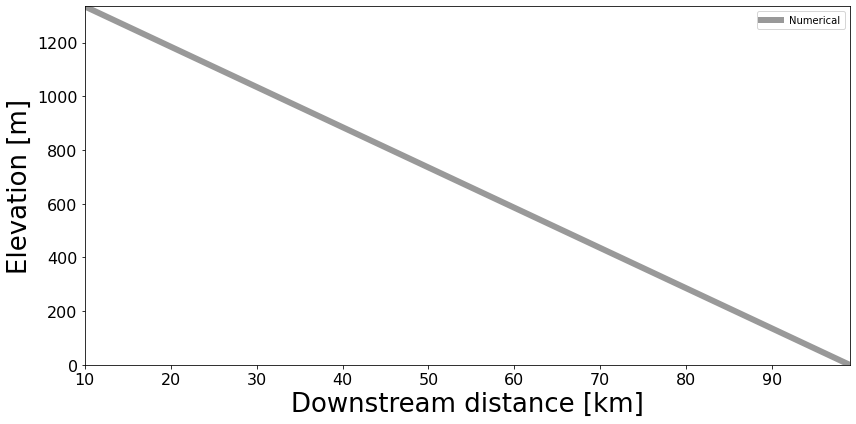

In [8]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(lp.x/1000., lp.z, '0.6', linewidth=6, label='Numerical')
plt.xlim(lp.x.min()/1000, lp.x.max()/1000)
plt.ylim(0, lp.z.max())
plt.xlabel('Downstream distance [km]', fontsize=26)
plt.ylabel('Elevation [m]', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.tight_layout()
plt.show()

Now, we can evolve the river profile, and calculate the analytical and numerical solutions.

In [9]:
# Numerical: (number of time steps, length of time step [s])
# note that this is a very long time step (31 Ma)
lp.evolve_threshold_width_river(1, 1E15)
# Analytical, no time steps, just solve for equilibrium profile.
zanalytical = lp.analytical_threshold_width() # suppress printing returned data.

We can now plot the analytical solution, and the numerical solution together. They match!

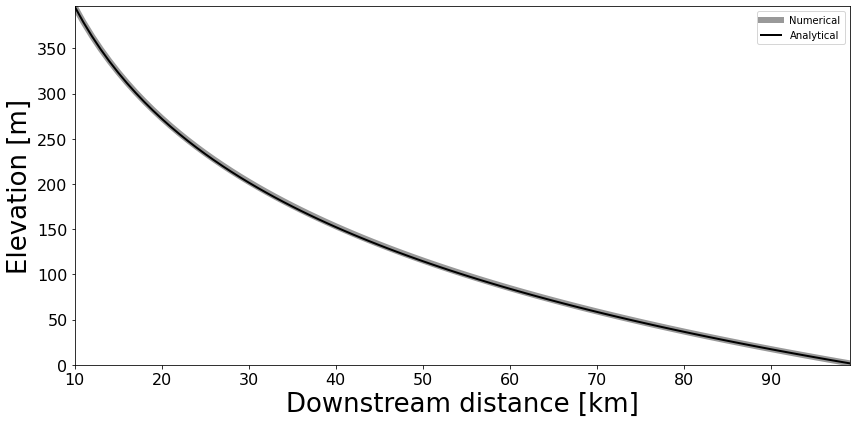

In [10]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(lp.x/1000., lp.z, '0.6', linewidth=6, label='Numerical')
plt.plot(lp.x/1000., lp.zanalytical, 'k', linewidth=2, label='Analytical')
plt.xlim(lp.x.min()/1000, lp.x.max()/1000)
plt.ylim(0, lp.z.max())
plt.xlabel('Downstream distance [km]', fontsize=26)
plt.ylabel('Elevation [m]', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.tight_layout()
plt.show()

So what is the geometry of this channel? The model object `lp` has a lot of attributes and methods. You can query them (like any other python object), using `dir()`.

In [11]:
# dir(lp)

And we can see that the object has an attribute `B` for valley width, and `b` for river width. If we query `B`...

In [12]:
# print(lp.B)

but if we query `b` we get...

In [13]:
print(lp.b)

None


because this information about channels (width, depth, etc.) is computed after the fact, and it requires knowledge of the grain size and sediment flux everywhere, which is not important for the long-profile evolution. So lets say the input grain size is 10 cm.

In [14]:
lp.D = 0.1
lp.compute_Q_s()
lp.compute_channel_width()
lp.compute_flow_depth()
print(lp.b)

[0.84496276 0.87128805 0.87119134 0.87117571 0.87121936 0.8713074
 0.87142935 0.87157764 0.87174667 0.87193221 0.87213101 0.87234053
 0.87255874 0.87278401 0.87301501 0.87325063 0.87348997 0.87373223
 0.87397675 0.87422296 0.87447036 0.87471851 0.87496703 0.87521557
 0.87546382 0.87571151 0.87595839 0.87620421 0.87644879 0.87669191
 0.87693341 0.87717311 0.87741086 0.87764651 0.87787994 0.87811101
 0.87833959 0.87856558 0.87878887 0.87900935 0.87922693 0.8794415
 0.87965299 0.8798613  0.88006635 0.88026806 0.88046635 0.88066115
 0.88085239 0.88103999 0.8812239  0.88140404 0.88158036 0.88175278
 0.88192126 0.88208573 0.88224613 0.88240242 0.88255454 0.88270243
 0.88284605 0.88298534 0.88312026 0.88325075 0.88337678 0.8834983
 0.88361526 0.88372761 0.88383533 0.88393835 0.88403665 0.88413017
 0.88421889 0.88430277 0.88438175 0.88445581 0.88452491 0.88458902
 0.88464809 0.88470209 0.884751   0.88479476 0.88483335 0.88486674
 0.88489489 0.88491778 0.88493536 0.88494761 0.8849545  0.884956 

And we can plot these things too.

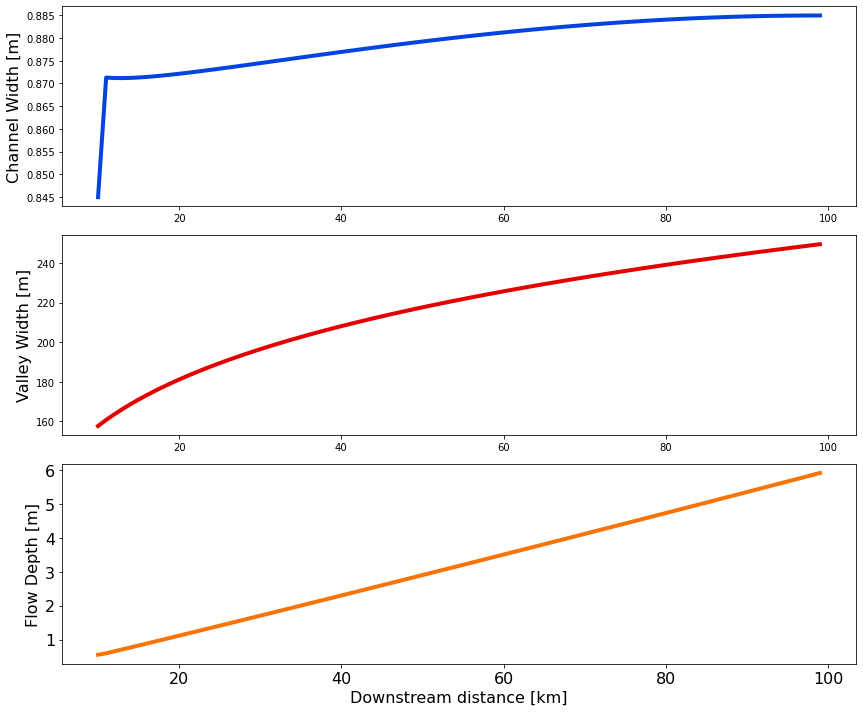

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.b, 'xkcd:blue', linewidth=4)
axes[1].plot(lp.x/1000., lp.B, 'xkcd:red', linewidth=4)
axes[2].plot(lp.x/1000., lp.h, 'xkcd:orange', linewidth=4)
axes[2].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_ylabel('Channel Width [m]', fontsize=16)
axes[1].set_ylabel('Valley Width [m]', fontsize=16)
axes[2].set_ylabel('Flow Depth [m]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()


This is the basic usage of the model, which is for a given long-profile of a single stream, calculate the equilibrium profile. 
Now, there are plenty of situations where the analytical profile would not be expected to match the numerical profile, because there are several simplifying assumptions applied to the analytical solution to render the math tractable.
2. Uplift is assumed to match river incision exactly for the analytical solution.
1. Discharge, Drainage Area, and Valley Width must be specified functions of downstream distance. However, the model does not specify _why_ that should be, only that it is. So if the downstream function of these variables is anything but a power law, the solutions should be different. 

So, for fun, let's violate #1 and see how it goes.
First, we will make a copy of the existing object using `deepcopy`, then we will change the boundary conditions, and run each of them forward. 

In [16]:
lp_uplift = deepcopy(lp)
lp_uplift.set_uplift_rate(1e-10) # in [m/s]

lp_uplift.evolve_threshold_width_river(1, 1E15) # evolve for the same amount of time as lp
_ = lp_uplift.analytical_threshold_width()

lp.evolve_threshold_width_river(1, 1E15) # this is unnecessary, but it's not expensive
_ = lp.analytical_threshold_width()

lp.compute_Q_s()
lp.compute_channel_width()
lp.compute_flow_depth()

lp_uplift.compute_Q_s()
lp_uplift.compute_channel_width()
lp_uplift.compute_flow_depth()

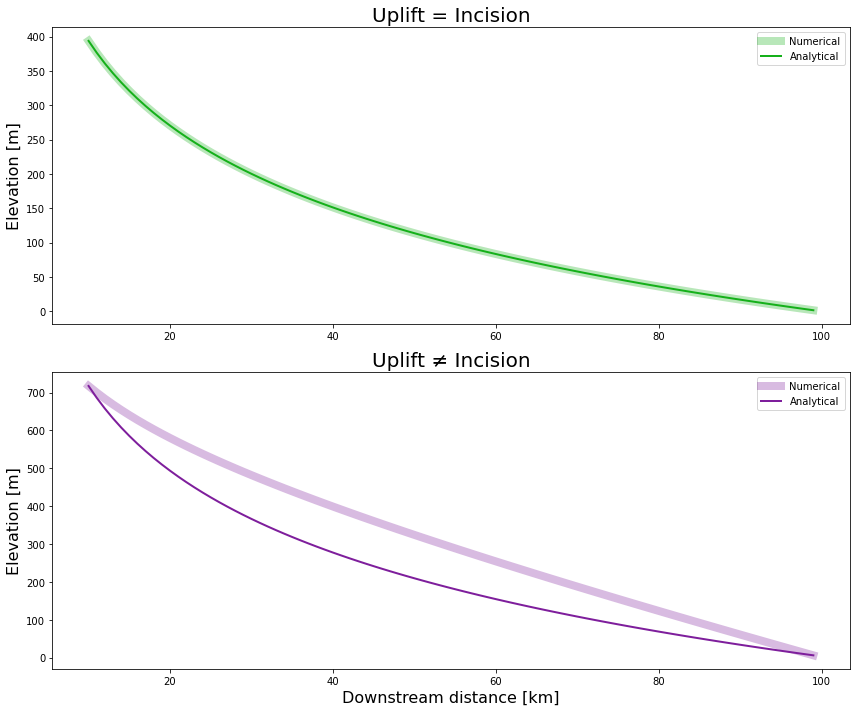

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.z, 'xkcd:green', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[0].plot(lp.x/1000., lp.zanalytical, 'xkcd:green', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].plot(lp.x/1000., lp_uplift.z, 'xkcd:purple', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[1].plot(lp.x/1000., lp_uplift.zanalytical, 'xkcd:purple', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_title('Uplift = Incision', fontsize = 20)
axes[1].set_title('Uplift ≠ Incision', fontsize = 20)
for a in axes:
    a.set_ylabel('Elevation [m]', fontsize=16)
    a.legend()
    a.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

Violating #2 does other interesting stuff.

In [18]:
# Screw with transfer functions between drainage area (A), discharge (Q), and valley width (B).
# Instead of power laws, these are now either constants, or a linear function 
# (drainage area has to increase downstream --- that's just geometry)

lp_constantQBA = deepcopy(lp)

lp_constantQBA.set_Q(Q = np.repeat(lp.Q[0], len(lp.x)))
lp_constantQBA.set_B(B = np.repeat(lp.B[0], len(lp.x)))
lp_constantQBA.set_A(A = lp.x * np.repeat(lp.A[0], len(lp.x)))

In [19]:
lp_constantQBA.evolve_threshold_width_river(1, 1E15) # evolve for the same amount of time as lp
_ = lp_constantQBA.analytical_threshold_width()

lp_constantQBA.compute_Q_s()
lp_constantQBA.compute_channel_width()
lp_constantQBA.compute_flow_depth()

lp.evolve_threshold_width_river(1, 1E15) # this is unnecessary, but it's not expensive
_ = lp.analytical_threshold_width()

lp.compute_Q_s()
lp.compute_channel_width()
lp.compute_flow_depth()

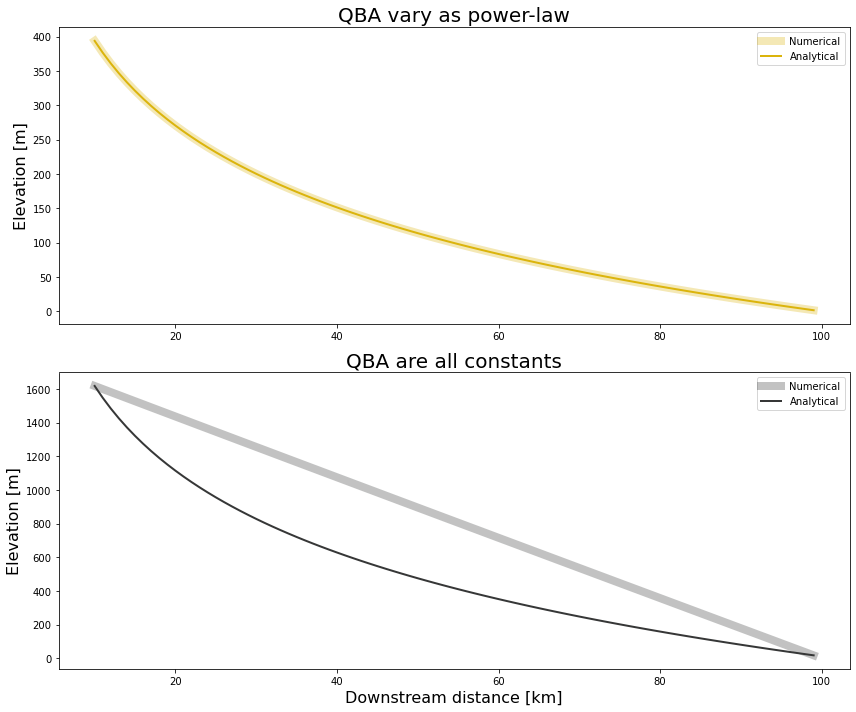

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.z, 'xkcd:gold', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[0].plot(lp.x/1000., lp.zanalytical, 'xkcd:gold', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].plot(lp.x/1000., lp_constantQBA.z, 'xkcd:dark grey', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[1].plot(lp.x/1000., lp_constantQBA.zanalytical, 'xkcd:dark grey', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_title('QBA vary as power-law', fontsize = 20)
axes[1].set_title('QBA are all constants', fontsize = 20)
for a in axes:
    a.set_ylabel('Elevation [m]', fontsize=16)
    a.legend()
    a.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

The river can also evolve through time! Till now, this tutorial uses _really_ big timesteps (300 My), but the model can also resolve shorter time. Here's a quick example, where an sudden increase in uplift rate is applied to the upstream end of our original channel profile `lp`.

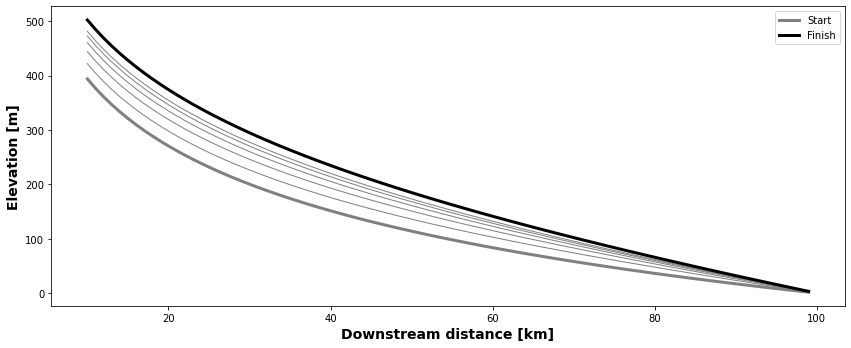

In [21]:
lp_increase = deepcopy(lp)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)
plt.xlabel('Downstream distance [km]', fontsize=14, fontweight='bold')
plt.ylabel('Elevation [m]', fontsize=14, fontweight='bold')
plt.tight_layout()

# Initial condition
ax1.plot(lp.x/1000., lp_increase.z, color='.5', linewidth=3, label = 'Start')

# Transient
U = 1E-3
lp_increase.set_uplift_rate(U/3.15E7)
for i in range(5):
    lp_increase.evolve_threshold_width_river(1, 1E12) # five timesteps of 31 ka
    ax1.plot(lp_increase.x/1000., lp_increase.z, color='.5', linewidth=1)

# New equilibrium
lp_increase.evolve_threshold_width_river(1, 1E14) # final state 3 Ma later
ax1.plot(lp.x/1000., lp_increase.z, color='0', linewidth=3, label = 'Finish')

ax1.legend()
